# 1. Read and check data

In [1]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
def get_info(df, print_null):
    df_shape = df.shape
    print ("\nThe dataframe has %s data and %s features" %(df_shape[0], df_shape[1]))
    #
    features_obj = list(df.select_dtypes(include=['object']).columns)
    print ("\nThe number of object features: %s" %(len(features_obj)))
    for feature in features_obj:
        if (print_null):
            num_null = df[feature].isnull().sum()
            if (num_null > 0):
                print ("%50s has %8d null values (%7.2f%%)" %(feature, num_null, num_null/df_shape[0]*100))
    #
    features_num = list(df.select_dtypes(exclude=['object']).columns)
    print ("\nThe number of numeric features: %s" %(len(features_num)))
    for feature in features_num:
        if (print_null):
            num_null = df[feature].isnull().sum()
            if (num_null > 0):
                print ("%50s has %8d null values (%7.2f%%)" %(feature, num_null, num_null/df_shape[0]*100))

In [3]:
dataset = pd.read_csv('training.csv')
get_info(dataset, print_null= True)


The dataframe has 72983 data and 34 features

The number of object features: 15
                                              Trim has     2360 null values (   3.23%)
                                          SubModel has        8 null values (   0.01%)
                                             Color has        8 null values (   0.01%)
                                      Transmission has        9 null values (   0.01%)
                                         WheelType has     3174 null values (   4.35%)
                                       Nationality has        5 null values (   0.01%)
                                              Size has        5 null values (   0.01%)
                              TopThreeAmericanName has        5 null values (   0.01%)
                                         PRIMEUNIT has    69564 null values (  95.32%)
                                          AUCGUART has    69564 null values (  95.32%)

The number of numeric features: 19
             

In [4]:
# Droping ID
feature = "RefId"
dataset.drop(labels=feature, axis='columns', inplace=True)

# Check for duplicated data
dataset[dataset.duplicated(keep=False)].index

Int64Index([], dtype='int64')

In [5]:
def check_target_bibary(df, target_feature):
    unique_target_vals = df[target_feature].unique()
    print ("\nUnique values of the target:", unique_target_vals)

In [6]:
check_target_bibary(df=dataset, target_feature='IsBadBuy')


Unique values of the target: [0 1]


In [7]:
def check_target_balance(df, target_feature):
    target_vals = df[target_feature]
    len_target_vals = len(target_vals)
    sum_target_vals = sum(target_vals)
    frac1 = sum_target_vals/ len_target_vals
    frac0 = 1-frac1
    print ("fraction of (%s==0): %6.2f" %(target_feature, frac0*100))
    print ("fraction of (%s==1): %6.2f" %(target_feature, frac1*100))

In [8]:
check_target_balance(df=dataset, target_feature='IsBadBuy')

fraction of (IsBadBuy==0):  87.70
fraction of (IsBadBuy==1):  12.30


In [9]:
def select_imbalanced_data(df, target_feature):
    target_vals = df[target_feature]
    len_target_vals = len(target_vals)
    n_target_1 = sum(target_vals)
    n_target_0 = len_target_vals-n_target_1
    #
    if (n_target_1 < n_target_0):
        df_minor = df[df[target_feature]==1]
        df_major = df[df[target_feature]==0]
    else:
        df_major = df[df[target_feature]==1]
        df_minor = df[df[target_feature]==0]
    return [df_minor, df_major]

In [10]:
downsample, upsample = select_imbalanced_data(df=dataset, target_feature='IsBadBuy')

###  Split 

In [11]:
from sklearn.model_selection import train_test_split

def split_train_validation_test(df, train_size, validation_size, test_size):
    train_validation, test = train_test_split(df, test_size=test_size)
    train, validation = train_test_split(train_validation, test_size=validation_size/(validation_size+train_size))
    return train, validation, test

In [12]:
train_size=0.6
validation_size=0.2
test_size=0.2

train_upsample, validation_upsample, test_upsample = split_train_validation_test(
    df=upsample,
    train_size=train_size,
    validation_size=validation_size,
    test_size=test_size)

train_downsample, validation_downsample, test_downsample = split_train_validation_test(
    df=downsample,
    train_size=train_size,
    validation_size=validation_size,
    test_size=test_size)

validation = pd.concat([validation_downsample, validation_upsample], ignore_index=True)
test = pd.concat([test_downsample, test_upsample], ignore_index=True)

In [13]:
from sklearn.utils import resample

def balance_data(downsample, upsample, do_increase, target_feature):
    n_downsample = downsample.shape[0]
    n_upsample = upsample.shape[0]
    print ( "The number of downsample and upsample data are: %s %s" %(n_downsample, n_upsample))
    if (do_increase):
        print ("\nUp-sample Minority Class")
        downsample_increase = resample(downsample, replace=True, n_samples=n_upsample, random_state=123)
        balance_data = pd.concat([downsample_increase, upsample])
        print (balance_data[target_feature].value_counts())
    else:
        print ("\nDown-sample Majority Class")
        upsample_decrease = resample(upsample, replace=False, n_samples=n_downsample, random_state=123)
        balance_data = pd.concat([downsample, upsample_decrease])
        print (balance_data[target_feature].value_counts())
    return balance_data

In [14]:
train = balance_data(train_downsample, train_upsample, do_increase=True, target_feature='IsBadBuy')

The number of downsample and upsample data are: 5385 38403

Up-sample Minority Class
1    38403
0    38403
Name: IsBadBuy, dtype: int64


### 1. Numeric variables

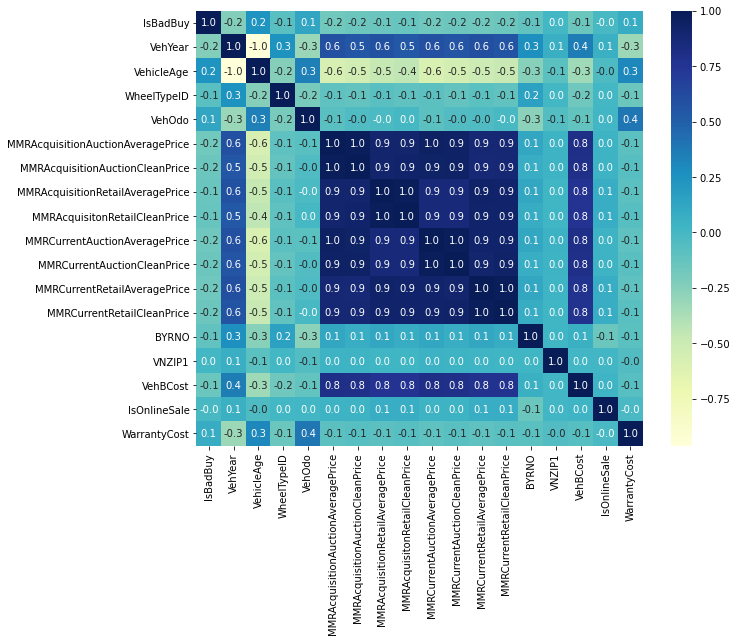

In [15]:
col_num = list(train.select_dtypes(include=['float64','int64']).columns)
corr = train[col_num].corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap="YlGnBu", annot=True, fmt=".1f")
plt.show()

In [16]:
def call_drop(feature, train, validation, test):
    train.drop(labels=feature, axis='columns', inplace=True)
    validation.drop(labels=feature, axis='columns', inplace=True)
    test.drop(labels=feature, axis='columns', inplace=True)

In [17]:
get_info(df=train,print_null=False)


The dataframe has 76806 data and 33 features

The number of object features: 15

The number of numeric features: 18


In [18]:
feature = "VehYear"
call_drop(feature, train=train, validation=validation, test=test)

feature = "MMRAcquisitionAuctionAveragePrice"
call_drop(feature, train=train, validation=validation, test=test)

feature = "MMRAcquisitionAuctionCleanPrice"
call_drop(feature, train=train, validation=validation, test=test)

feature = "MMRAcquisitionRetailAveragePrice"
call_drop(feature, train=train, validation=validation, test=test)

feature = "MMRAcquisitonRetailCleanPrice"
call_drop(feature, train=train, validation=validation, test=test)

feature = "MMRCurrentAuctionAveragePrice"
call_drop(feature, train=train, validation=validation, test=test)

feature = "MMRCurrentAuctionCleanPrice"
call_drop(feature, train=train, validation=validation, test=test)

feature = "MMRCurrentRetailAveragePrice"
call_drop(feature, train=train, validation=validation, test=test)

feature = "MMRCurrentRetailCleanPrice"
call_drop(feature, train=train, validation=validation, test=test)

In [19]:
# Create the function to plot figures
def his_plot(df, features_plot, target_feature, ncolplot, rot_ang_xaxis):
    nfig = len(features_plot)
    nrowplot = np.int(np.ceil(nfig/ncolplot))
    fig, axs = plt.subplots(nrowplot, ncolplot, figsize=(16,16))
    labels = [target_feature + " = 1", target_feature + " = 0"]
    num = 0
    for feature in features_plot:
        data_hist = [df[df[target_feature]==1][feature].dropna(), df[df[target_feature]==0][feature].dropna()]
        id_row = int(num/ncolplot)
        id_col = num-id_row*ncolplot
        try:
            axs[id_row,id_col].hist(data_hist, label=labels)
            axs[id_row,id_col].legend(prop={'size': 10})
            axs[id_row,id_col].set_title(feature)
            axs[id_row,id_col].xaxis.set_tick_params(rotation=rot_ang_xaxis)
        except:
            axs[id_col].hist(data_hist, label=labels)
            axs[id_col].legend(prop={'size': 10})
            axs[id_col].set_title(feature)
            axs[id_col].xaxis.set_tick_params(rotation=rot_ang_xaxis)
        num += 1

['IsBadBuy', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


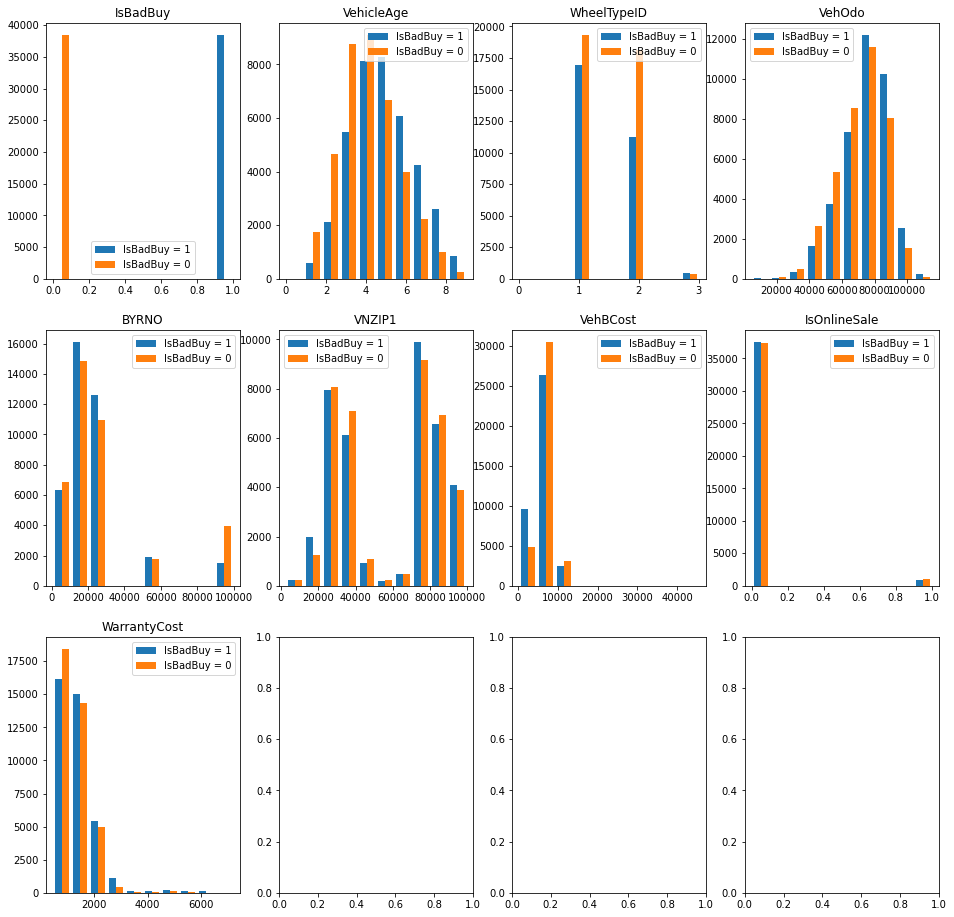

In [20]:
col_num = list(train.select_dtypes(include=['float64','int64']).columns)
print (col_num)

his_plot(df=train, features_plot=col_num, target_feature='IsBadBuy', ncolplot=4, rot_ang_xaxis = 0)

In [21]:
feature = "IsOnlineSale"
call_drop(feature, train=train, validation=validation, test=test)

### 2. Objective variables

['PurchDate', 'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST']


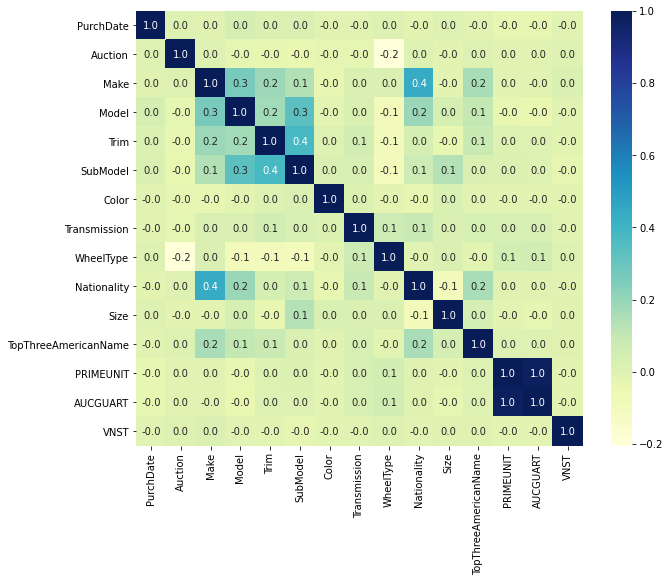

In [22]:
col_object = list(train.select_dtypes(include=['object']).columns)
print (col_object)

df = train[col_object]
corr = df.apply(lambda x: x.factorize()[0]).corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap="YlGnBu", annot=True, fmt=".1f")
plt.show()

In [23]:
feature = "PRIMEUNIT"
call_drop(feature, train=train, validation=validation, test=test)

In [24]:
col_object = list(train.select_dtypes(include=['object']).columns)
print (col_object)

['PurchDate', 'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'AUCGUART', 'VNST']


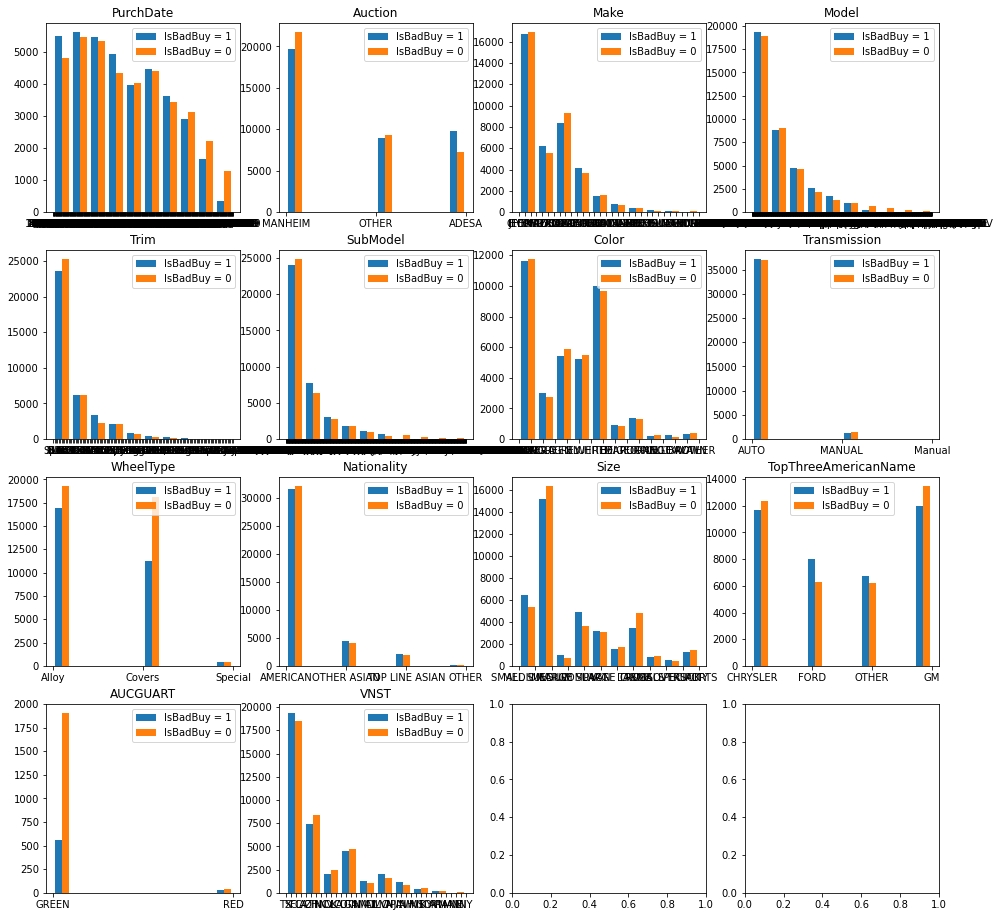

In [25]:
his_plot(df=train, features_plot=col_object, target_feature='IsBadBuy', ncolplot=4, rot_ang_xaxis = 0)

In [26]:
feature = "Transmission"
call_drop(feature, train=train, validation=validation, test=test)

feature = "AUCGUART"
call_drop(feature, train=train, validation=validation, test=test)

In [27]:
col_object = list(train.select_dtypes(include=['object']).columns)

for col in col_object:
    print (col, ":  the number of unique data: ", len(train[col].unique()))
    if (len(train[col].unique()) < 20):
        print (train[col].unique())
    print ()

PurchDate :  the number of unique data:  516

Auction :  the number of unique data:  3
['MANHEIM' 'OTHER' 'ADESA']

Make :  the number of unique data:  32

Model :  the number of unique data:  983

Trim :  the number of unique data:  130

SubModel :  the number of unique data:  780

Color :  the number of unique data:  17
['BLACK' 'SILVER' 'GOLD' 'GREEN' 'GREY' 'BLUE' 'WHITE' 'RED' 'BEIGE'
 'MAROON' 'PURPLE' 'ORANGE' 'YELLOW' 'NOT AVAIL' 'BROWN' 'OTHER' nan]

WheelType :  the number of unique data:  4
['Alloy' 'Covers' nan 'Special']

Nationality :  the number of unique data:  5
['AMERICAN' 'OTHER ASIAN' 'TOP LINE ASIAN' 'OTHER' nan]

Size :  the number of unique data:  13
['SMALL SUV' 'MEDIUM SUV' 'MEDIUM' 'LARGE SUV' 'COMPACT' 'VAN'
 'LARGE TRUCK' 'LARGE' 'CROSSOVER' 'SMALL TRUCK' 'SPECIALTY' 'SPORTS' nan]

TopThreeAmericanName :  the number of unique data:  5
['CHRYSLER' 'FORD' 'OTHER' 'GM' nan]

VNST :  the number of unique data:  37



In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76806 entries, 21131 to 71012
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IsBadBuy              76806 non-null  int64  
 1   PurchDate             76806 non-null  object 
 2   Auction               76806 non-null  object 
 3   VehicleAge            76806 non-null  int64  
 4   Make                  76806 non-null  object 
 5   Model                 76806 non-null  object 
 6   Trim                  73960 non-null  object 
 7   SubModel              76798 non-null  object 
 8   Color                 76798 non-null  object 
 9   WheelTypeID           66480 non-null  float64
 10  WheelType             66471 non-null  object 
 11  VehOdo                76806 non-null  int64  
 12  Nationality           76804 non-null  object 
 13  Size                  76804 non-null  object 
 14  TopThreeAmericanName  76804 non-null  object 
 15  BYRNO          

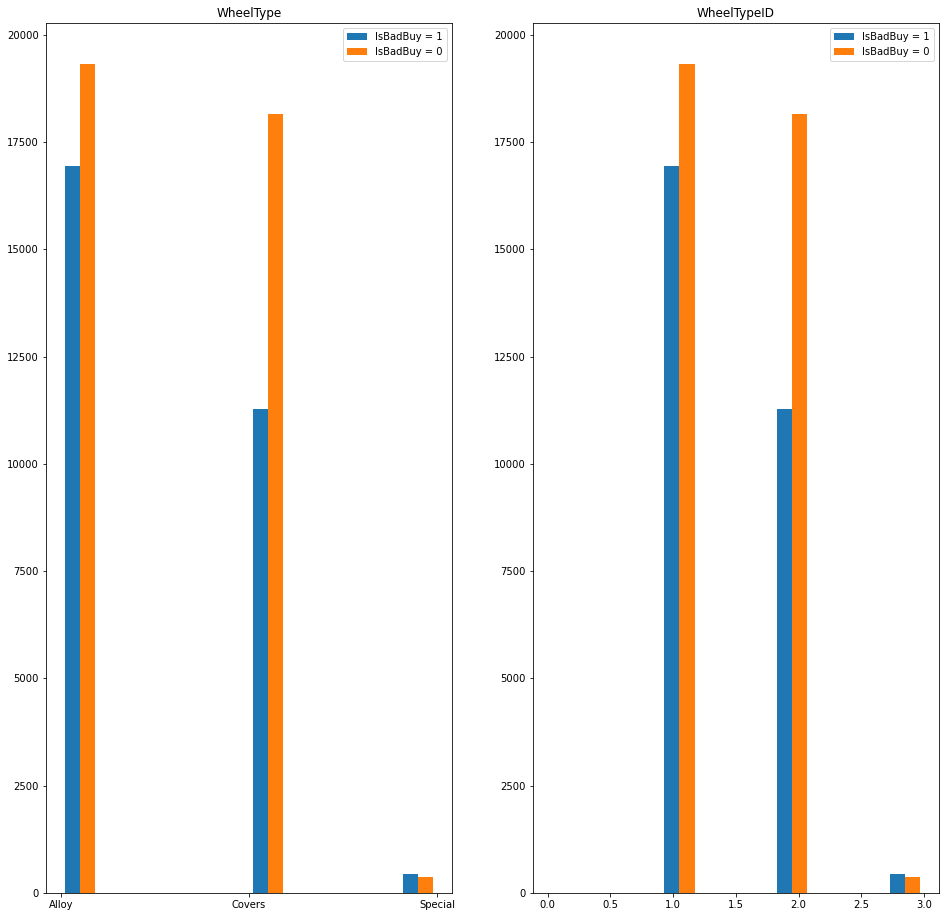

In [29]:
col_plot = ['WheelType','WheelTypeID']
his_plot(df=train, features_plot=col_plot, target_feature='IsBadBuy', ncolplot=2, rot_ang_xaxis = 0)

In [30]:
feature = "WheelTypeID"
call_drop(feature, train=train, validation=validation, test=test)

## 2. Deal with missing values

<p>Let's take a look at what missing values we'll have to handle.</p> For the numeric variable, replace null by median and for the category variable, most popular value is used to fill null

In [31]:
def fill_missing(df):
    all_null = df.columns[df.isnull().any()]
    for col in all_null:
        try:
            df[col].fillna(df[col].mode()[0], inplace=True)
        except:
            df[col].fillna(df[col].median(), inplace=True)

In [32]:
def fill_missing_train_validation_test(train, validation, test):
    ntrain = train.shape[0]
    nvalidation = validation.shape[0]
    ntest = test.shape[0]
    print (ntrain, nvalidation, ntest)
    #
    df = pd.concat([train, validation, test], ignore_index=True)
    print (df.shape[0])
    all_null = df.columns[df.isnull().any()]
    for col in all_null:
        try:
            df[col].fillna(df[col].mode()[0], inplace=True)
        except:
            df[col].fillna(df[col].median(), inplace=True)
    train = df[:ntrain]
    validation = df[ntrain:ntrain+nvalidation]
    test = df[-ntest:]
    return train, validation, test

In [33]:
#fill_missing(train)
#fill_missing(validation)
#fill_missing(test)

In [34]:
get_info(train, print_null=True)
get_info(validation, print_null=True)


The dataframe has 76806 data and 19 features

The number of object features: 12
                                              Trim has     2846 null values (   3.71%)
                                          SubModel has        8 null values (   0.01%)
                                             Color has        8 null values (   0.01%)
                                         WheelType has    10335 null values (  13.46%)
                                       Nationality has        2 null values (   0.00%)
                                              Size has        2 null values (   0.00%)
                              TopThreeAmericanName has        2 null values (   0.00%)

The number of numeric features: 7

The dataframe has 14597 data and 19 features

The number of object features: 12
                                              Trim has      505 null values (   3.46%)
                                         WheelType has      632 null values (   4.33%)
                    

In [35]:
train, validation, test = fill_missing_train_validation_test(train=train, validation=validation, test=test)

76806 14597 14598
106001


### Deal with date

In [36]:
def deal_with_date(df, date_feature):
    print ("\nDeal with date-feature:", date_feature)
    df[date_feature] = pd.to_datetime(df[date_feature])
    print ("\nDate data ranges from:", df[date_feature].min(), " to:", df[date_feature].max() )
    print ("which has total", df[date_feature].max() - df[date_feature].min())
    #
    df['Year'] = df[date_feature].dt.year
    df['Month'] = df[date_feature].dt.month
    df['Day'] = df[date_feature].dt.day
    df['Day_Name'] = df[date_feature].dt.day_name()
    df['Day_Name_Num'] = df[date_feature].dt.dayofweek
    #
    df['sinMonth'] = np.sin(df['Month'] * 2.0 *np.pi/12.0)
    df['cosMonth'] = np.cos(df['Month'] * 2.0 *np.pi/12.0)
    df['sinDay'] = np.sin(df['Day'] * 2.0 *np.pi/30.0)
    df['cosDay'] = np.cos(df['Day'] * 2.0 *np.pi/30.0)
    df['sinDay_Name_Num'] = np.sin(df['Day_Name_Num'] * 2.0 *np.pi/7.0)
    df['cosDay_Name_Num'] = np.cos(df['Day_Name_Num'] * 2.0 *np.pi/7.0)


In [37]:
deal_with_date(df=train, date_feature='PurchDate')
deal_with_date(df=validation, date_feature='PurchDate')
deal_with_date(df=test, date_feature='PurchDate')


Deal with date-feature: PurchDate

Date data ranges from: 2009-01-05 00:00:00  to: 2010-12-30 00:00:00
which has total 724 days 00:00:00

Deal with date-feature: PurchDate

Date data ranges from: 2009-01-05 00:00:00  to: 2010-12-30 00:00:00
which has total 724 days 00:00:00

Deal with date-feature: PurchDate

Date data ranges from: 2009-01-05 00:00:00  to: 2010-12-30 00:00:00
which has total 724 days 00:00:00


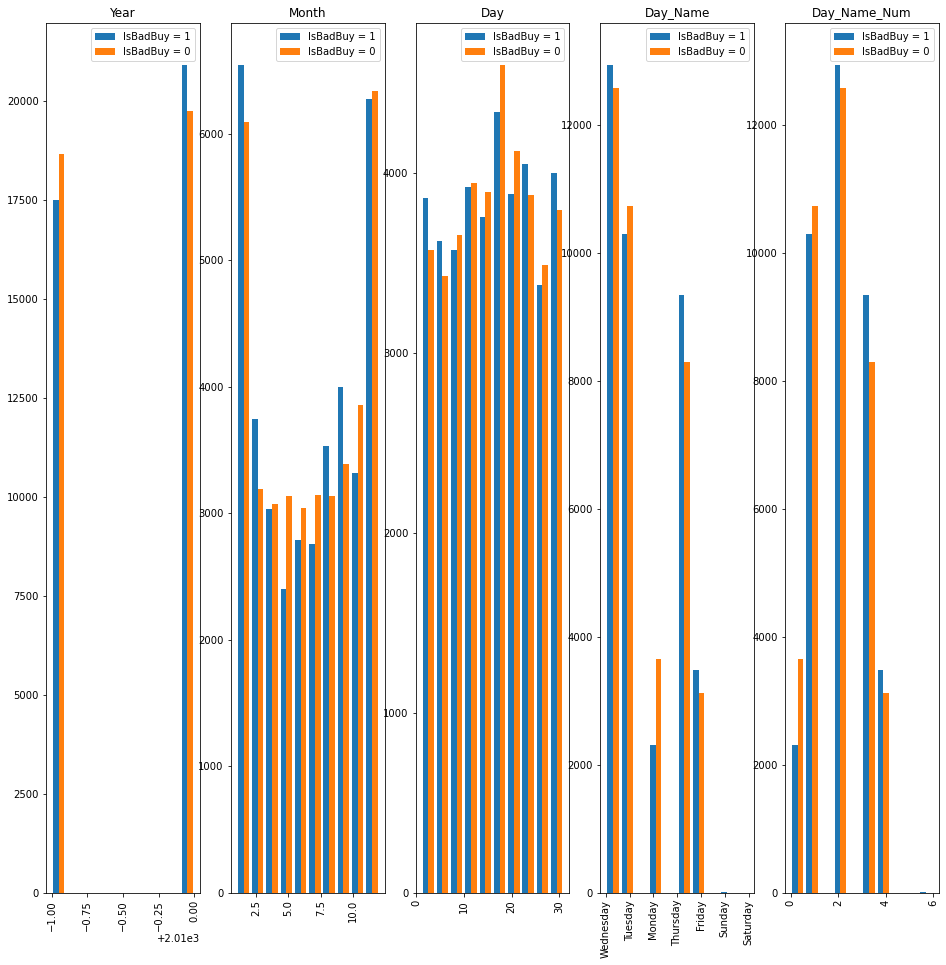

In [38]:
col_plot = ['Year', 'Month', 'Day', 'Day_Name', 'Day_Name_Num']
his_plot(df=train, features_plot=col_plot, target_feature='IsBadBuy', ncolplot=5, rot_ang_xaxis = 90)

In [39]:
feature = "PurchDate"
call_drop(feature, train=train, validation=validation, test=test)
feature = "Month"
call_drop(feature, train=train, validation=validation, test=test)
feature = "Day"
call_drop(feature, train=train, validation=validation, test=test)
feature = "Day_Name_Num"
call_drop(feature, train=train, validation=validation, test=test)
feature = "Day_Name"
call_drop(feature, train=train, validation=validation, test=test)

In [40]:
print (list(train))
print (list(validation))
print (list(test))

['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost', 'WarrantyCost', 'Year', 'sinMonth', 'cosMonth', 'sinDay', 'cosDay', 'sinDay_Name_Num', 'cosDay_Name_Num']
['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost', 'WarrantyCost', 'Year', 'sinMonth', 'cosMonth', 'sinDay', 'cosDay', 'sinDay_Name_Num', 'cosDay_Name_Num']
['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost', 'WarrantyCost', 'Year', 'sinMonth', 'cosMonth', 'sinDay', 'cosDay', 'sinDay_Name_Num', 'cosDay_Name_Num']


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def Encode_object(train, validation, test, Encode):
    if (Encode=='Drop'):
        res_train = train.select_dtypes(exclude=['object'])
        res_validation = validation.select_dtypes(exclude=['object'])
        res_test = test.select_dtypes(exclude=['object'])
    elif (Encode=='Label'):
        col_object = list(train.select_dtypes(include=['object']).columns)
        res_train = train.copy()
        res_validation = validation.copy()
        res_test = test.copy()
        # Apply label encoder to each column with categorical data
        label_encoder = LabelEncoder()
        for col in col_object:
            label_encoder.fit(pd.concat([train[col], validation[col], test[col]], axis=0, sort=False))
            res_train[col] = label_encoder.transform(train[col])
            res_validation[col] = label_encoder.transform(validation[col])
            res_test[col] = label_encoder.transform(test[col])
    elif (Encode=='OneHot'):
        col_object = list(train.select_dtypes(include=['object']).columns)
        # Apply one-hot encoder to each column with categorical data
        OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train[col_object]))
        OH_cols_validation = pd.DataFrame(OH_encoder.transform(validation[col_object]))
        OH_cols_test = pd.DataFrame(OH_encoder.transform(validation[col_object]))
        # One-hot encoding removed index; put it back
        OH_cols_train.index = train.index
        OH_cols_validation.index = validation.index
        OH_cols_test.index = test.index
        # numerical features are kept
        num_train = train.drop(col_object, axis=1)
        num_validation = validation.drop(col_object, axis=1)
        num_test = test.drop(col_object, axis=1)
        # Add one-hot encoded columns to numerical features
        res_train = pd.concat([num_train, OH_cols_train], axis=1)
        res_validation = pd.concat([num_validation, OH_cols_validation], axis=1)
        res_test = pd.concat([num_test, OH_cols_test], axis=1)
    return res_train, res_validation, res_test

In [42]:
last_train, last_validation, last_test = Encode_object(
    train=train,
    validation=validation,
    test=test,
    Encode='Label')

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score


def RFC_(train, validation, test, target_feature):
    print ("\nValidation data checking")
    check_target_balance(df=validation, target_feature=target_feature)
    print ("\nTest data checking")
    check_target_balance(df=test, target_feature=target_feature)
    #
    y_train = train[target_feature]
    X_train = train.drop(target_feature, axis=1)
    y_validation = validation[target_feature]
    X_validation = validation.drop(target_feature, axis=1)
    y_test = test[target_feature]
    X_test = test.drop(target_feature, axis=1)
    #
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train,y_train)
    #
    y_pred = rfc.predict(X_validation)
    print ("\nModel performance on validation-data")
    print("Accuracy:", accuracy_score(y_validation, y_pred))    
    prob_y = rfc.predict_proba(X_validation)
    prob_y = [p[1] for p in prob_y]
    print('roc_auc_score', roc_auc_score(y_validation, prob_y) )
    #
    y_pred = rfc.predict(X_test)
    print ("\nModel performance on test-data")
    print("Accuracy:", accuracy_score(y_test, y_pred))    
    prob_y = rfc.predict_proba(X_test)
    prob_y = [p[1] for p in prob_y]
    print('roc_auc_score', roc_auc_score(y_test, prob_y) )

In [49]:
RFC_(train=last_train, validation=last_validation, test=last_test, target_feature='IsBadBuy')


Validation data checking
fraction of (IsBadBuy==0):  87.70
fraction of (IsBadBuy==1):  12.30

Test data checking
fraction of (IsBadBuy==0):  87.70
fraction of (IsBadBuy==1):  12.30

Model performance on validation-data
Accuracy: 0.8731246146468452
roc_auc_score 0.6893490266797623

Model performance on test-data
Accuracy: 0.8741608439512262
roc_auc_score 0.6840017993778116


In [ ]:
huy = aa

###  Diving in (machine learning)

<p>Now that the data has been cleaned, we can try to find a model that works well for making our predictions. We'll also load in some classifiers which we will compare.</p>

### Model 1: Evaluate using train_test_split

In [ ]:
huy = aa

In [ ]:
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(n_estimators=100)
rfc_cv_score = cross_val_score(rfc, X, y, cv=5, scoring='roc_auc')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

### Model 2: Pipeline and cross_val_score

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()), ('model', RandomForestClassifier(n_estimators=100, random_state=1234567))])

from sklearn.model_selection import cross_val_score

scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')

print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

### Model 3: GridSearchCV

In [ ]:
RFC = RandomForestClassifier()

# Use kfold as our cross validation
kfold = StratifiedKFold(n_splits=5)

# Set grid search parameter settings
#n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 3)]
n_estimators = [100]

# max depth
#max_depth = [int(x) for x in np.linspace(5, 50, num = 2)]
#max_depth.append(None)
max_depth = [None]

rfc_param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}

#rfc_param_grid = {'n_estimators': [100]}

# Perform grid searches to get estimators with the optimal settings
grid_search = GridSearchCV(estimator=RFC, param_grid=rfc_param_grid, n_jobs=1, cv=kfold, verbose=1)

grid_search.fit(X, y)

print (grid_search.best_score_)